In [1]:
import pandas as pd
import numpy as np
import scipy as sp

from scipy import interp

import itertools

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.path import Path
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer


import operator as op

from tqdm import tqdm_notebook, tnrange

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [2]:
np.random.seed(42)

In [3]:
sns.set()
sns.set_context("notebook", font_scale=2, rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set(font_scale=2, rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

In [4]:
burst_oscore_cols = [ 'burst_oscore_12.0_20.0', 'burst_oscore_20.0_30.0',
       'burst_oscore_3.0_8.0', 'burst_oscore_30.0_60.0',
       'burst_oscore_60.0_90.0', 'burst_oscore_8.0_12.0']

burst_params = [ ]

spiketrain_params = ['AI', 'burst_spike_percent', 'cv', 'firing_rate', 'frequency_variance', 'isi_mean', 'isi_median', 'isi_std',
                    'isi_larger_than_mean', 'kurtoisis', 'skewness', 'lv', 'nu', 
                     'oscore_12.0_20.0', 'oscore_20.0_30.0', 'oscore_3.0_8.0', 'oscore_30.0_60.0',
                     'oscore_60.0_90.0', 'oscore_8.0_12.0','interburst_interval', 'mean_burst_len', 'ratio_burst_time',
                    'mean_isi_in_burst', 'median_isi_in_burst', 'mean_spikes_in_burst']

recording_params = ['doc_name', 'interval_name', 'data_name', 'spike_count', 'filter_length']
useless_params = ['burst_index',  'pause_index', 'modalirity_burst', 'bi_2', 'type', 'burst_behaviour', 'pause_ratio']

In [5]:
data_awake = pd.read_excel('awake.xls')

data_awake = data_awake.rename(columns={'burst_mean':'AI', 'burst_percent':'isi_larger_than_mean'})
data_awake = data_awake[spiketrain_params + burst_params  + recording_params + ['patient']]

data_awake = data_awake[(data_awake['mean_spikes_in_burst'] > 0) & (data_awake['mean_spikes_in_burst'] < 100)]
data_awake['mean_burst_len'] = data_awake['mean_burst_len'].astype(float)

In [6]:
data_sleep = pd.read_excel('sleep.xls')
data_sleep = data_sleep.rename(columns={'burst_mean':'AI', 'burst_percent':'isi_larger_than_mean'})

data_sleep = data_sleep[spiketrain_params + burst_params + recording_params + ['patient']]

data_sleep = data_sleep[ (data_sleep['mean_spikes_in_burst'] > 0) & (data_sleep['mean_spikes_in_burst'] < 100)]
data_sleep['mean_burst_len'] = data_sleep['mean_burst_len'].astype(float)

In [7]:
data_sleep['awake'] = 0
data_awake['awake'] = 1

data = pd.concat([data_sleep, data_awake], ignore_index=True)

data = data[data['filter_length'] > 5]
data = data.drop(recording_params, axis=1)

data = data.sample(frac=1).reset_index(drop=True)

patients = data['patient']
data = data.drop(['patient'], axis=1)

old_cols = list(data.columns.values)
data.columns = list(range(1, len(old_cols) + 1))

# spiketrain_idx = [old_cols.index(p) + 1 for p in spiketrain_params]
# burst_idx = [old_cols.index(p) + 1 for p in burst_params]

In [8]:
print(data.shape)

(375, 26)


In [9]:
data.columns.values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

In [10]:
data_sleep.shape, data_awake.shape

((149, 32), (226, 32))

In [11]:
data.to_csv('without_burst_oscore.csv', index=False)

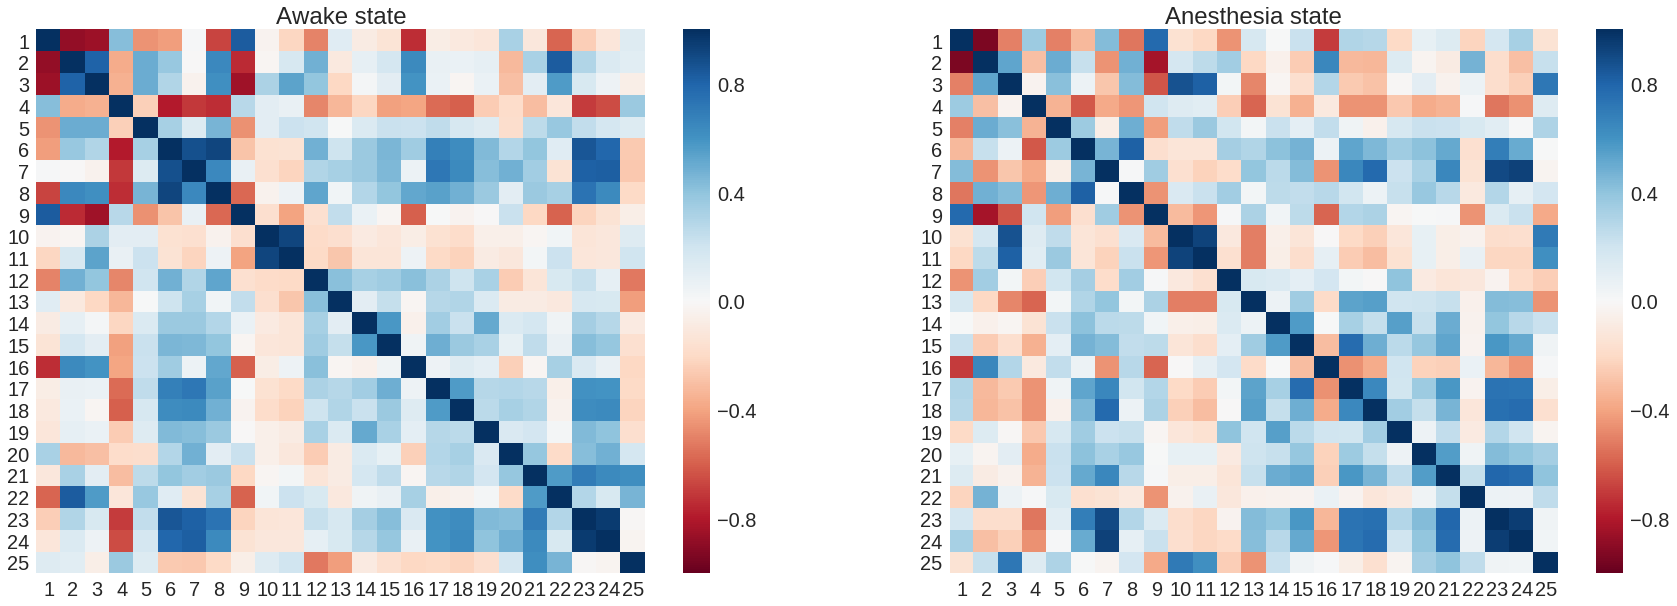

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(30,10))

awake_corr = data[data[old_cols.index('awake') + 1] == 1].drop(old_cols.index('awake') + 1, axis=1).corr()
sleep_corr = data[data[old_cols.index('awake') + 1] == 0].drop(old_cols.index('awake') + 1, axis=1).corr()

sns.heatmap(awake_corr, ax=ax1, cmap='RdBu')
sns.heatmap(sleep_corr, ax=ax2, cmap='RdBu')
ax1.set_title('Awake state')
ax2.set_title('Anesthesia state')

In [13]:
class PatientsFold(object):
    def __init__(self, patients):
        self.patients = np.array(patients)
        
    def split(self, X, y=None):
        for p in set(patients):
            is_pat = (patients == p)
            not_pat = np.logical_not(is_pat)
            
            is_pat = np.where(is_pat)
            not_pat = np.where(not_pat)
            
            yield not_pat[0], is_pat[0]
        
        return

In [14]:
def simple_cv(X, y, patients, model_type, params=None, plot=True, ax=None, ret_arr = False):
    
    if model_type == 'xgb':
        model = xgb.XGBClassifier(**params)
    elif model_type == 'linear':
        model = LogisticRegression()
    elif model_type == 'rf':        
        model = RandomForestClassifier(**params)
    
    if plot and ax is None:
        f, ax = plt.subplots(figsize=(15,10))
    
    classifier = Pipeline([('n', Normalizer()),('m', model)])
    acc = np.mean(cross_val_score(classifier, X, y, scoring='accuracy', cv=5))
    
    cv = StratifiedKFold(n_splits=5)
    tprs = []
    aucs = []
    accs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    i = 0
    for train, test in cv.split(X, y):
        preds_ = classifier.fit(X.as_matrix()[train], y.as_matrix()[train]).predict(X.as_matrix()[test])
        probas_ = classifier.fit(X.as_matrix()[train], y.as_matrix()[train]).predict_proba(X.as_matrix()[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        if plot:
            ax.plot(fpr, tpr, lw=1, alpha=0.3)
        accs.append(accuracy_score(y[test], preds_))
        i += 1
    


    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    if plot:
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
        ax.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc) + '\n' +
                        r'Mean Accuracy (%0.3f $\pm$ %0.3f)' % (np.mean(accs), np.std(accs)),
                 lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

        ax.set_xlim([-0.05, 1.05])
        ax.set_ylim([-0.05, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=13)
        ax.set_ylabel('True Positive Rate', fontsize=13)
#         ax.set_title('Receiver operating characteristic example')
        ax.legend(loc="lower right", prop={'size': 16})
    
    if ret_arr:
        return accs, mean_auc
    else:
        return np.mean(accs), mean_auc

In [15]:
def patient_cv(X, y, patients, model_type, params=None, plot=True, ax=None):
    if model_type == 'xgb':
        model = xgb.XGBClassifier(**params)
    elif model_type == 'linear':
        model = LogisticRegression()
    elif model_type == 'rf':        
        model = RandomForestClassifier(**params)
    
    if plot and ax is None:
        f, ax = plt.subplots(figsize=(15,10))
    
    classifier = Pipeline([('n', Normalizer()),('m', model)])
#     acc = np.mean(cross_val_score(classifier, X, y, scoring='accuracy', cv=5))
    
    cv = PatientsFold(patients)
    tprs = []
    aucs = []
    accs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    i = 0
    for train, test in cv.split(X, y):
        preds_ = classifier.fit(X.as_matrix()[train], y.as_matrix()[train]).predict(X.as_matrix()[test])
        probas_ = classifier.fit(X.as_matrix()[train], y.as_matrix()[train]).predict_proba(X.as_matrix()[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.as_matrix()[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        accs.append(accuracy_score(y.as_matrix()[test], preds_))
        if plot:
            ax.plot(fpr, tpr, lw=1, alpha=0.3)

        i += 1

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    if plot:
        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
        ax.plot(mean_fpr, mean_tpr, color='b',
                 label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc) + '\n' +
                        r'Mean Accuracy (%0.3f $\pm$ %0.3f)' % (np.mean(accs), np.std(accs)),
                 lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

        ax.set_xlim([-0.05, 1.05])
        ax.set_ylim([-0.05, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=13)
        ax.set_ylabel('True Positive Rate', fontsize=13)
#         ax.set_title('Receiver operating characteristic example')
        ax.legend(loc="lower right", prop={'size': 16})

    return np.mean(accs), mean_auc

In [16]:
data_names = pd.concat([data_sleep, data_awake], ignore_index=True)
data_names['awake'] = data_names['awake'].apply(lambda s: 'awake' if s == 1 else 'anesthesia')

In [17]:
data_names = data_names[(data_names['cv'] < 20) & (data_names['isi_mean'] < 0.3) & (data_names['isi_std'] < 1.)
                        & (data_names['kurtoisis'] < 300) & (data_names['mean_isi_in_burst'] < 0.08)]

In [18]:
def get_pval_code(pval):
    if pval <= 0.001:
        return '***'
    elif pval <= 0.01:
        return '**'
    elif pval <= 0.05:
        return '*'
    else:
        return 'ns'

In [19]:
def pirateplot(x, y, data, figsize=(15,10), ax=None):
    bx = sns.boxplot(x=x, y=y, data=data, showfliers=False, ax=ax)
    vx = sns.violinplot(x=x, y=y, data=data, inner=None, ax=ax)
    sx = sns.swarmplot(x=x, y=y, data=data, color=".25", ax=ax)
 
    for c in vx.collections:
        c.set_alpha(0.25)
    
    if ax is None:
        w_lines = [3, 4, 8, 9]
    else:
        w_lines = [2, 3, 7, 8]

    for l_idx in w_lines:
        l = bx.get_lines()[l_idx]
        old_path = l.get_path()._vertices
        x1, x2 = old_path[0][0], old_path[1][0]
        m = (x1+x2)/2
        old_path[0][0] = (x1+m)/2
        old_path[1][0] = (m+x2)/2

        l._path = Path(old_path)

In [20]:
asleep_idx = data_names['awake'] == 'anesthesia'
awake_idx = data_names['awake'] == 'awake' 

feature_pval = dict()

for c in data_names.drop(['awake', 'patient'] + recording_params, axis=1).columns:
    sleep_data = data_names[asleep_idx][c]
    awake_data = data_names[awake_idx][c]
    
    sleep_means = list()
    awake_means = list()
    
    for p in data_sleep['patient'].unique():
        m = data_sleep[data_sleep['patient'] == p][c].mean()
        sleep_means.append(m)
        
    for p in data_awake['patient'].unique():
        m = data_awake[data_awake['patient'] == p][c].mean()
        awake_means.append(m)   
    
    stat, pval = sp.stats.ttest_ind(sleep_means, awake_means)
    
    feature_pval[c] = pval
    print(round(pval, 5))

0.00059
0.00023
8e-05
0.03782
0.00017
0.03723
0.555
0.01083
2e-05
0.01313
0.00032
0.73829
0.0008
0.32843
0.83221
0.00841
0.5097
0.85915
0.05391
0.42957
0.06433
0.00082
0.0844
0.0861
0.00588


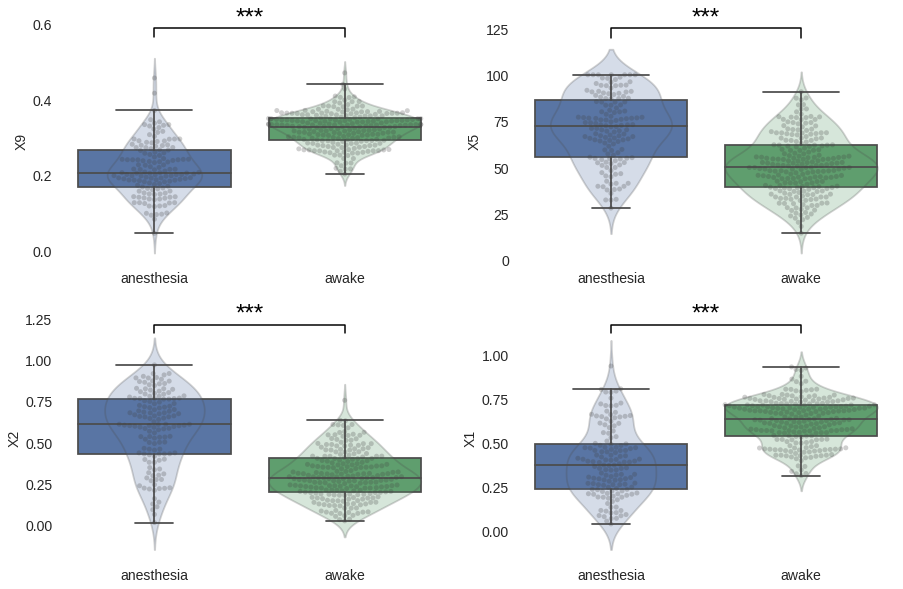

In [21]:
interesing_idx = [9, 5, 2, 1]

fig, axs = plt.subplots(figsize=(15,10), nrows=2, ncols=2)

asleep_idx = data_names['awake'] == 'anesthesia'
awake_idx = data_names['awake'] == 'awake' 

for ax, c in zip(axs.flatten(), [old_cols[i-1] for i in interesing_idx]):
    sleep_data = data_names[asleep_idx][c]
    awake_data = data_names[awake_idx][c]

#     stat, pval = sp.stats.mannwhitneyu(sleep_data, awake_data)
    pval_code = get_pval_code(feature_pval[c])

    x1, x2 = 0, 1 

    c_max = data_names[c].max()
    y, h, col = c_max*1.2, c_max*0.05, 'k'

    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, pval_code, ha='center', va='bottom', color=col)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
        
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)

    pirateplot('awake', c, data_names, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('X{}'.format(old_cols.index(c) + 1), fontsize=14)

In [22]:
# interesing_idx = [1, 2, 5, 9, 16, 13]

# asleep_idx = data_names['awake'] == 'anesthesia'
# awake_idx = data_names['awake'] == 'awake' 

# for c in [old_cols[i-1] for i in interesing_idx]:
#     sleep_data = data_names[asleep_idx][c]
#     awake_data = data_names[awake_idx][c]

#     stat, pval = sp.stats.mannwhitneyu(sleep_data, awake_data)
#     pval_code = get_pval_code(pval)

#     plt.figure(figsize=(10,10))
# #         sns.distplot(sleep_data, color='blue', label='sleep', kde=False)
# #         sns.distplot(awake_data, color='red', label='awake', kde=False)
# #         plt.legend()
# #         plt.autoscale()

#     x1, x2 = 0, 1 

#     c_max = data_names[c].max()
#     y, h, col = c_max*1.2, c_max*0.05, 'k'

#     plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#     plt.text((x1+x2)*.5, y+h, pval_code, ha='center', va='bottom', color=col)

#     pirateplot('awake', c, data_names)
#     plt.xlabel('')
#     plt.ylabel('X{}'.format(old_cols.index(c) + 1))

In [26]:
def fix_params(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
#     params['max_features'] = int(params['max_features'])
    
    return params

def score(X, y, patients, pbar, cv_type, model_type, metric, params):
    params = fix_params(params)
    
    if cv_type == 'patient':
        accuracy, auc = patient_cv(X, y, patients, model_type, params, plot=False)
    elif cv_type == 'simple':
        accuracy, auc = simple_cv(X, y, patients, model_type, params, plot=False)
    else:
        raise RuntimeError('Uknown cv type!')
    
    if metric == 'auc':
        loss = -auc
    elif metric == 'accuracy':
        loss = -accuracy
    else:
        raise RuntimeError('Uknown metric for scoring!')
        
    pbar.update(1)
    
    return {'loss': loss, 'status': STATUS_OK}

def optimize(X, y, patients, trials, cv_type='simple', model_type='xgb', metric='accuracy', max_evals=250):
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
#              'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
             'max_depth' : hp.quniform('max_depth', 1, 13, 1),
#              'max_features': hp.quniform('max_features', 1, X.shape[1], 1),
             }
    
    pbar = tqdm_notebook(total=max_evals)
    best_params = fmin(lambda params: score(X, y, patients, pbar, cv_type, model_type, metric, params), 
                       space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

    return fix_params(best_params)

In [27]:
X = data.drop(old_cols.index('awake') + 1, axis=1)
y = data[old_cols.index('awake') + 1]

In [28]:
def calculate_fscore(X, y):
    awake_idx = np.where(y == 1)
    asleep_idx = np.where(y == 0)
    
    res = dict()
    
    for c in X.columns.values:
        data_asleep = X[c].iloc[asleep_idx]
        data_awake = X[c].iloc[awake_idx]
        
        awake_mean = np.mean(data_awake)
        asleep_mean = np.mean(data_asleep)
        feature_mean = X[c].mean()
        
        num = ((awake_mean - feature_mean )**2 + (asleep_mean - feature_mean)**2)
        den = 1./(data_awake.shape[0] - 1)*np.sum((v - awake_mean)**2 for v in data_awake) +\
              1./(data_sleep.shape[0] - 1)*np.sum((v - asleep_mean)**2 for v in data_asleep)
            
        res[c] = num/den
        
    return res

In [29]:
f_scores = calculate_fscore(X, y)

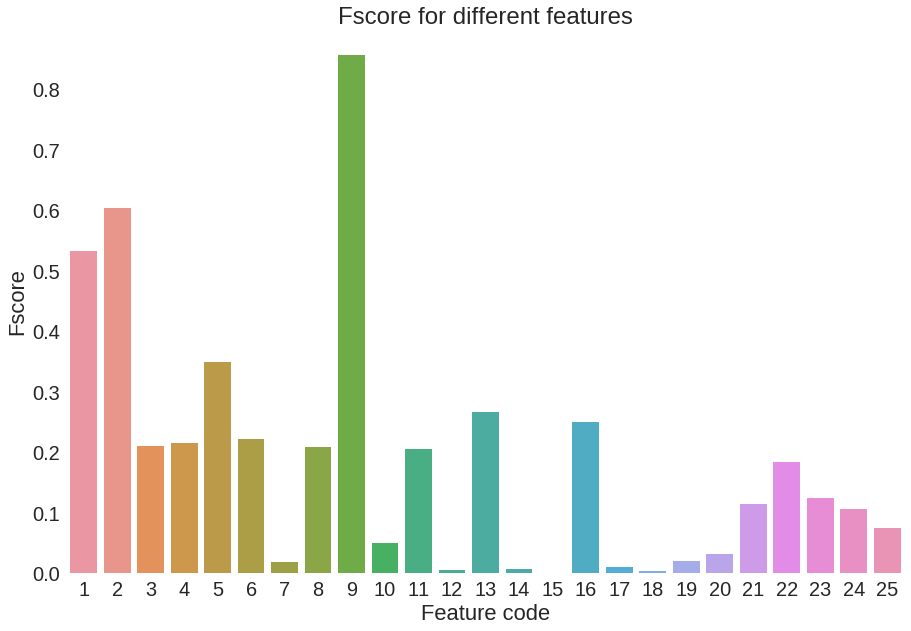

In [30]:
plt.figure(figsize=(15,10))
sns.barplot(list(f_scores.keys()), list(f_scores.values()))

plt.title('Fscore for different features')
plt.xlabel('Feature code')
plt.ylabel('Fscore')

In [31]:
for f, sc in f_scores.items():
    print(f, sc)

1 0.531427245638
2 0.603369251718
3 0.209691616248
4 0.215379412932
5 0.347653807264
6 0.220759931342
7 0.017153398626
8 0.208631905975
9 0.855773338694
10 0.0493586799437
11 0.204255671288
12 0.00474436652195
13 0.266490727502
14 0.00674038897825
15 0.000159460514044
16 0.249374718243
17 0.00915614809927
18 0.00216148805304
19 0.0188358313692
20 0.0305425347985
21 0.113646646708
22 0.182515112487
23 0.123323747975
24 0.105114400345
25 0.0743489408897


In [32]:
def find_best_pair(X, y, thresh=0.25):
    res = list()
    for p in itertools.combinations(X.columns.values, 2):
        p = list(p)
        
        if any(f_scores[v] > thresh for v in p):
            continue

        X_curr = X[p]
        score, _ = simple_cv(X_curr, y, None, 'linear', plot=False, ret_arr=True)
        
        res.append((p, score))
    
    return res     

In [33]:
pair_scores = find_best_pair(X, y, thresh=0.9)

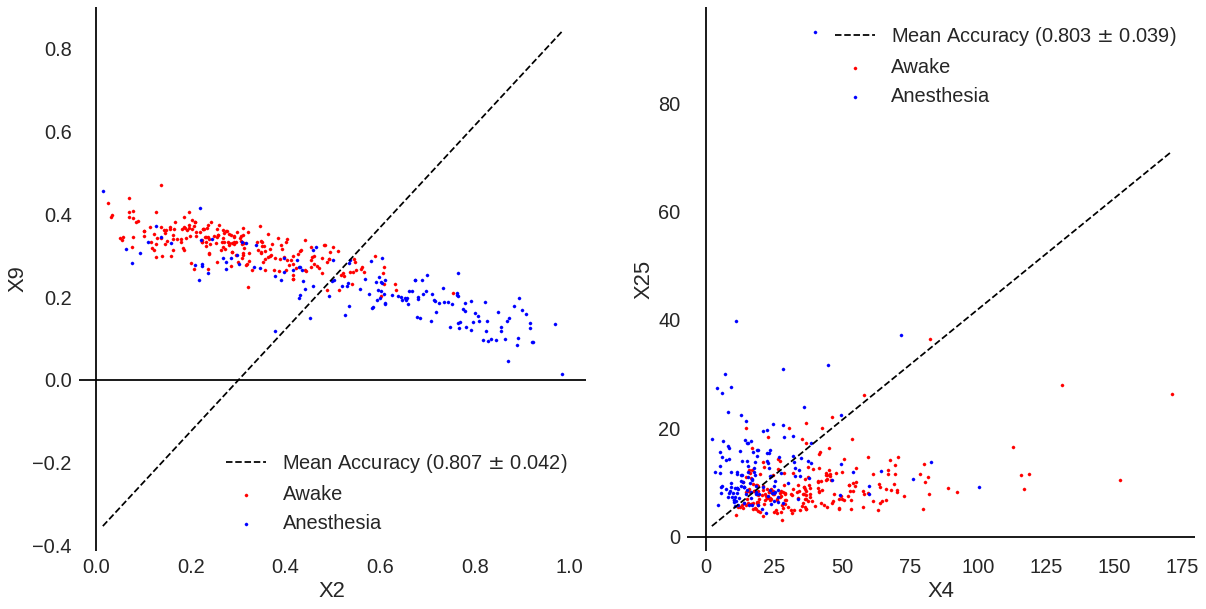

In [34]:
y_awake = np.where(y == 1)
y_asleep = np.where(y == 0)

fig, axs = plt.subplots(ncols=2,figsize=(20,10))

i = 0
for p, s in pair_scores:
    if p == [4, 25] or p == [2, 9]:
        ax = axs[i]
        i += 1

        X_curr = X[p]

        X_curr_awake = X_curr.iloc[y_awake].as_matrix()
        X_curr_asleep = X_curr.iloc[y_asleep].as_matrix()

        model = LogisticRegression()
        model.fit(X_curr, y)

        w0 = model.intercept_
        w1, w2 = model.coef_[0]

#         plt.figure(figsize=(10, 7))
        ax.scatter(X_curr_awake[:, 0], X_curr_awake[:, 1], color='red', label='Awake', s=10)
        ax.scatter(X_curr_asleep[:, 0], X_curr_asleep[:, 1], color='blue', label='Anesthesia', s=10)

        l = np.array([np.min(X_curr[p[0]]), X_curr[p[0]].max()])
        
        if p == [2, 9]:
            ax.plot(l, (-w0-w1*l)/w2, color='black', ls='--', label=r'Mean Accuracy (%0.3f $\pm$ %0.3f)' % (np.mean(s) - 0.025, np.std(s)))
        else:
            ax.plot(l, (-w0-w1*l)/w2, color='black', ls='--', label=r'Mean Accuracy (%0.3f $\pm$ %0.3f)' % (np.mean(s), np.std(s)))

        ax.set_xlabel('X{}'.format(p[0]))
        ax.set_ylabel('X{}'.format(p[1]))
        
        ax.axhline(y=0, color='black')
        ax.axvline(0, color='black')
                
        ax.legend()

In [35]:
trials = Trials()
best_params_pat = optimize(X, y, patients, trials, cv_type='patient', model_type='rf')

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anacond

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meanin

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meanin

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meani

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anacond

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meanin

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meanin

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meanin

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meanin

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meani

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meani

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meanin

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anacond

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meanin

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meani

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meanin

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meanin

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meani

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meani

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meani

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meanin

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anacond

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meanin

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meanin

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meanin

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meani

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meani

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anacond

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meanin

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:96: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
/home/vladka/anacond

/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/vladka/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:534: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meanin

In [36]:
trials = Trials()
best_params_simple = optimize(X, y, patients, trials, model_type='rf', cv_type='simple')

KeyboardInterrupt: 

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15,20))

st_acc, st_auc = patient_cv(X, y, patients, 'rf', best_params_pat, ax=ax1)
burst_acc, burst_auc = simple_cv(X, y, patients, 'rf', best_params_simple, ax=ax2)

# ax1.set_title('accuracy={}'.format(round(st_acc, 3)))
# ax2.set_title('accuracy={}'.format(round(burst_acc, 3)))

acc, auc_score = patient_cv(X, y, patients, 'linear', None, ax=ax3)
# ax3.set_title('accuracy={}'.format(round(acc, 3)))

acc, auc_score = simple_cv(X, y, patients, 'linear', None, ax=ax4)
# ax4.set_title('accuracy={}'.format(round(acc, 3)))

pad = 5
for ax, col in zip([ax1, ax2], ('CV by patients', 'Simple CV')):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
            xycoords='axes fraction', textcoords='offset points',
            size=18, ha='center', va='baseline')

for ax, row in zip([ax1, ax3], ('Random Forest', 'Linear model')):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
            xycoords=ax.yaxis.label, textcoords='offset points',
            size=18, ha='right', va='center')

In [32]:
data.to_csv('without_burst_oscore.csv', index=False)

In [33]:
for c, idx in zip(old_cols, data.columns.values):
    print('X{} : {}'.format(idx, c))

X1 : AI
X2 : burst_spike_percent
X3 : cv
X4 : firing_rate
X5 : frequency_variance
X6 : isi_mean
X7 : isi_median
X8 : isi_std
X9 : isi_larger_than_mean
X10 : kurtoisis
X11 : skewness
X12 : lv
X13 : nu
X14 : oscore_12.0_20.0
X15 : oscore_20.0_30.0
X16 : oscore_3.0_8.0
X17 : oscore_30.0_60.0
X18 : oscore_60.0_90.0
X19 : oscore_8.0_12.0
X20 : interburst_interval
X21 : mean_burst_len
X22 : ratio_burst_time
X23 : mean_isi_in_burst
X24 : median_isi_in_burst
X25 : mean_spikes_in_burst
X26 : awake


In [12]:
data.groupby(26).count()

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
26,,,,,,,,,,,,,,,,,,,,,
0,149,149,149,149,149,149,149,149,149,149,...,149,149,149,149,149,149,149,149,149,149
1,226,226,226,226,226,226,226,226,226,226,...,226,226,226,226,226,226,226,226,226,226


In [35]:
corr_diff = awake_corr - sleep_corr
big_diff = np.where(corr_diff.abs() < 0.1)

In [36]:
print('{0:20} {1:20} {2:10} {3:10}'.format('F1', 'F2', 'sleep corr', 'awake corr'))
print('*'*63)

for l, r in zip(big_diff[0], big_diff[1]):
    sc = round(sleep_corr[l+1][r+1], 4)
    ac = round(awake_corr[l+1][r+1], 4)
    
    if abs(ac) > 0.75 and ac != 1.0:        
        print('{0:20} {1:20} {2:10} {3:10}'.format(old_cols[l], old_cols[r], sc, ac))


F1                   F2                   sleep corr awake corr
***************************************************************
AI                   burst_spike_percent      -0.939    -0.8788
AI                   isi_larger_than_mean     0.7793     0.8324
burst_spike_percent  AI                       -0.939    -0.8788
isi_mean             isi_std                  0.8185     0.9144
isi_median           mean_isi_in_burst         0.899     0.8127
isi_std              isi_mean                 0.8185     0.9144
isi_larger_than_mean AI                       0.7793     0.8324
kurtoisis            skewness                 0.9232     0.9148
skewness             kurtoisis                0.9232     0.9148
mean_isi_in_burst    isi_median                0.899     0.8127
mean_isi_in_burst    median_isi_in_burst       0.953     0.9569
median_isi_in_burst  mean_isi_in_burst         0.953     0.9569


In [44]:
corr_diff = awake_corr - sleep_corr
big_diff = np.where(corr_diff.abs() > 0.3)

In [45]:
print('{0:20} {1:20} {2:10} {3:10}'.format('F1', 'F2', 'sleep corr', 'awake corr'))
print('*'*63)

for l, r in zip(big_diff[0], big_diff[1]):
    sc = round(sleep_corr[l+1][r+1], 4)
    ac = round(awake_corr[l+1][r+1], 4)
    
    if abs(ac) > 0.75 and ac != 1.0:        
        print('{0:20} {1:20} {2:10} {3:10}'.format(old_cols[l], old_cols[r], sc, ac))


F1                   F2                   sleep corr awake corr
***************************************************************
AI                   cv                      -0.5074    -0.8577
burst_spike_percent  ratio_burst_time         0.4711     0.8291
cv                   AI                      -0.5074    -0.8577
isi_mean             isi_median               0.4625     0.8824
isi_median           isi_mean                 0.4625     0.8824
ratio_burst_time     burst_spike_percent      0.4711     0.8291


In [23]:
data_awake[['spike_count', 'filter_length']].mean()

spike_count      632.911504
filter_length     15.562894
dtype: float64

In [22]:
data_sleep[['spike_count', 'filter_length']].mean()

spike_count      445.651007
filter_length     22.472151
dtype: float64

In [19]:
train_corr = data_awake.corr()

x_idx, y_idx = np.where( (train_corr < -0.8) & (train_corr != 1.) & np.triu(np.ones(train_corr.shape)).astype(np.bool))
x_idx, y_idx = train_corr.columns.values[x_idx], train_corr.columns.values[y_idx]

for x, y in zip(x_idx, y_idx):
    print('{0:20} {1:20} {2:10}'.format(x, y, train_corr[x][y]))

AI                   burst_spike_percent  -0.8788440964392594
AI                   cv                   -0.8577068698048973
cv                   isi_larger_than_mean -0.8453522469973319


In [208]:
data_names.groupby('patient')['spike_count', 'filter_length'].count()

,spike_count,filter_length
patient,,
Geroeva,67,67
Khitrov,21,21
Lisikova,40,40
Nazarenko,41,41
Novikov,33,33
Serebryanskiy,48,48
stepanova,82,82
zhigunov,36,36
